# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
from sklearn import preprocessing
import numpy as np

---
## Step 0: Load The Data

In [2]:
#test code to check if tensorflow recognizes my GPU

# import tensorflow as tf
# config = tf.ConfigProto(
#         device_count = {'GPU': 1}
#     )
# sess = tf.Session(config=config)
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# from tensorflow.python.client import device_lib
# print (device_lib.list_local_devices())

In [3]:
# Load pickled data
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.cross_validation import StratifiedShuffleSplit
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import csv
import cv2
import pandas as pd

# TODO: Fill this in based on where you saved the training and testing data
# Globals
training_file = 'train.p'
testing_file = 'test.p'

# Database class
class Database:
    def __init__(self, training_file, testing_file):
        pass

    def load(self):
        print ('Loading Databse')
        with open(training_file, mode='rb') as f:
            self.train = pickle.load(f)
        with open(testing_file, mode='rb') as f:
            self.test = pickle.load(f)
        self.signs = pd.read_csv("signnames.csv")
        self.X_train_original, self.y_train_original = self.train['features'], self.train['labels']
        self.X_test, self.y_test = self.test['features'], self.test['labels']
        
    def split_to_validation(self, test_size=0.3, random_state=0):
        print ('Splitting {0}% training set for validation'.format( str(test_size*100)) )
        sss = StratifiedShuffleSplit( list(self.y_train_original), test_size = 0.2,random_state=0)
        for train_index, val_index in sss:
            self.X_validation = self.X_train_original[val_index,:,:,:]
            self.X_train = self.X_train_original[train_index,:,:,:]
            self.y_validation = self.y_train_original[val_index]
            self.y_train = self.y_train_original[train_index]

    def check_assertions(self):
        assert(len(db.X_train) == len(db.y_train))
        assert(len(db.X_validation) == len(db.y_validation))
        assert(len(db.X_test) == len(db.y_test))
        print ('Data is valid')

    def shuffle_training_data(self):
        self.X_train, self.y_train = shuffle(self.X_train, self.y_train)
        self.X_validation, self.y_validation = shuffle(self.X_validation, self.y_validation)

        ## Various normalizations functions that I didn't end up using
        
#     ### normalize the data between range 0 to 1
#     def normalize_0_to_1(self, image_data):
#         image_data = image_data.astype('float32')
#         image_data = image_data / 255
#         return image_data
    
#     ### normalize the data between range -0.5 to +0.5
#     def normalize_0_mean(self, image_data):
#         image_data = image_data.astype('float32')
#         image_data = image_data / 255 - 0.5
#         return image_data

#     ### normalize the data between any range
#     def normalize_generic(self, image_data, start, end):
#         image_data = image_data.astype('float32')
#         image_data = start + (image_data / 255) - (end-start)
#         return image_data
#     # http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
    
#     def min_max_scaling_with_0_mean(self, image_data):
#         min_max_scaler = preprocessing.MinMaxScaler()
#         img_min_maxed_data = np.zeros_like(image_data, dtype=float)
#         for ch in range(image_data.shape[3]):
#             tmp = min_max_scaler.fit_transform(image_data[:,:,:,ch])
#             img_min_maxed_data[:,:,:,ch] = tmp
#         #print(np.max(img_normed_color))
#         #print(np.min(img_normed_color))
#         return img_min_maxed_data

    

    def normalize_grayscale(self, image_data):
        """
        Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
        :param image_data: The image data to be normalized
        :return: Normalized image data
        """
        img_max = np.max(image_data)
        img_min = np.min(image_data)
        a = 0.1
        b = 0.9

        img_normed = a + (b-a)*(image_data - img_min)/(img_max - img_min)
        #print(np.max(img_normed))
        #print(np.min(img_normed))
        return img_normed

    def normalize_color(self, image_data):
        """
        Normalize the image data on per channel basis. 
        """
        img_normed_color = np.zeros_like(image_data, dtype=float)
        for ch in range(image_data.shape[3]):
            tmp = self.normalize_grayscale(image_data[:,:,:,ch])
            img_normed_color[:,:,:,ch] = tmp
        #print(np.max(img_normed_color))
        #print(np.min(img_normed_color))
        return img_normed_color
    
#     def normalize(self, image_data):
# #         return normalize_0_to_1(image_data)
#         return preprocessing.normalize(image_data)



    ### Generate data additional data (OPTIONAL!)
    def rotate(self,img, angle_range):
        #angle_rotation = np.random.uniform(angle_range)-angle_range/2
        angle_rotation = angle_range
        rows,cols,ch = img.shape    
        Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),angle_rotation,1)
        img = cv2.warpAffine(img,Rot_M,(cols,rows))
        return img

    def rotate_test(self):
        index = random.randint(0, len(self.X_train))
        image = self.X_train[index].squeeze()
        img = self.rotate(image, 10)
        plt.figure(figsize=(2,2))
        plt.imshow(image)
        plt.imshow(img)
        
    def augment_training_data(self):
        X_rotated_images = []
        y_rotated_images = []
        uniqueLabels, counts = np.unique(self.y_train_original, return_counts=True)
        n_classes = uniqueLabels.shape[0]        
        train_bin_count = np.bincount(self.y_train_original)
        aug_freq = (200+np.max(train_bin_count)-train_bin_count)
        index = 0
        
        for c in range(n_classes):
#             plt.figure(figsize=(16, 16))
            for n in range(aug_freq[c]):
                image = self.X_train_original[np.random.randint(index, index+train_bin_count[c])].squeeze()
    #             index = random.randint(0, len(self.X_train))
    #             image = self.X_train[index].squeeze()
    #             plt.subplot(8, 8, n+1)
                rotated_image = self.rotate(image, np.random.randint(-15,15))
                X_rotated_images.append(rotated_image)
                y_rotated_images.append(c)
    #             plt.imshow(rotated_image)
    #             plt.figure()
    #             plt.imshow(self.X_train_original[np.random.random_integers(index, train_bin_count[c]-1)])
            index += train_bin_count[c]
        self.X_train_original = np.concatenate((self.X_train_original, X_rotated_images))
        self.y_train_original = np.concatenate((self.y_train_original, y_rotated_images))
#         for img,y in zip(X_train, y_train):
#             rotated_image = rotate(img, angle)
#             X_rotated_images.append(rotated_image)
#             y_rotated_images.append(y)
#         print(len(X_train))
#         print(len(X_rotated_images))
#         return X_rotated_images, y_rotated_images



/home/shobhitg/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:


db = Database(training_file, testing_file)
db.load()
# db.augment_training_data()

db.split_to_validation(0.2, 0)
db.check_assertions()



Loading Databse
Splitting 20.0% training set for validation
Data is valid


In [5]:
# # Creates a graph.
# import tensorflow as tf
# with tf.device('/gpu:0'):
#   a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#   b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#   c = tf.matmul(a, b)
# # Creates a session with log_device_placement set to True.
# sess = tf.Session(config=config)
# # Runs the op.
# print (sess.run(c))

In [6]:
# # Creates a graph.
# import tensorflow as tf
# a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
# b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
# c = tf.matmul(a, b)
# # Creates a session with log_device_placement set to True.
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# # Runs the op.
# print (sess.run(c))

In [7]:
# from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']
# print(get_available_gpus())

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [8]:
### Replace each question mark with the appropriate value.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import csv

# Visualizations will be shown in the notebook.
%matplotlib inline

class DataExplorer:
    def __init__(self, database_instance):
        self.db = database_instance

    def process(self):
        print ('Processing Databse for exploration')
        # TODO: Number of training examples
        self.n_train = self.db.X_train_original.shape[0]

        # TODO: Number of testing examples.
        self.n_test = self.db.X_test.shape[0]

        # TODO: What's the shape of an traffic sign image?
        self.image_shape = self.db.X_test.shape[1:]

        # TODO: How many unique classes/labels there are in the dataset.
        self.uniqueLabels, self.counts = np.unique(self.db.y_train_original, return_counts=True)
        self.n_classes = self.uniqueLabels.shape[0]

        self.label_names = self.read_label_names('signnames.csv')
        self.train_bin_count = np.bincount(data_exp.db.y_train_original)
        
    def print_summary(self):
        print("Number of training examples =", self.n_train)
        print("Number of testing examples =", self.n_test)
        print("Image data shape =", self.image_shape)
        print("Number of classes =", self.n_classes)
        print("Bin Count", self.train_bin_count)

    def read_label_names(self, filename):
        with open(filename, newline='', encoding="utf8") as csvfile:
            spamreader = csv.reader(csvfile)
            vals = [x[1] for x in spamreader][1:]
            return vals
    
    def draw_histogram(self):
        plt.figure()
        plt.hist(self.db.y_train,
                 self.n_classes,
                 normed=True,
                 color='#45CCFF',
                 alpha=0.75,
                label='Training set')
        plt.title('Histogram of Training Set')
        plt.legend(loc='upper right')
        plt.show()

        plt.figure()
        plt.hist(self.db.y_validation,
                 np.unique(self.db.y_train_original).shape[0],
                 normed=True,
                 color='#49E83E',
                 alpha=0.75,
                label='Validation set')
        plt.title('Histogram of Test Set')
        plt.legend(loc='upper right')        
        plt.show()
        
        plt.figure()
        plt.hist(self.db.y_test,
                 np.unique(self.db.y_validation).shape[0],
                 normed=True,
                 color='#a9788E',
                 alpha=0.75,
                label='Test set')
        plt.title('Histogram of Validation Set')
        plt.legend(loc='upper right')        
        plt.show()
        
    def show_images_each_class(self):
        index = 0

        fig = plt.figure(figsize=(32, 32))
        for c in range(self.n_classes):
            plt.subplot(16, 4, c+1)
#             plt.subplots_adjust(hspace=0.7)
            plt.axis('off')
            fig.subplots_adjust(left=0.15, top=1.5)

            plt.title(self.db.signs.SignName[c], fontsize=32)
            plt.imshow(self.db.X_train_original[np.random.randint(index, index+self.train_bin_count[c])])
            index += self.train_bin_count[c]


In [9]:
data_exp = DataExplorer(db)
data_exp.process()
data_exp.print_summary()

Processing Databse for exploration
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Bin Count [ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

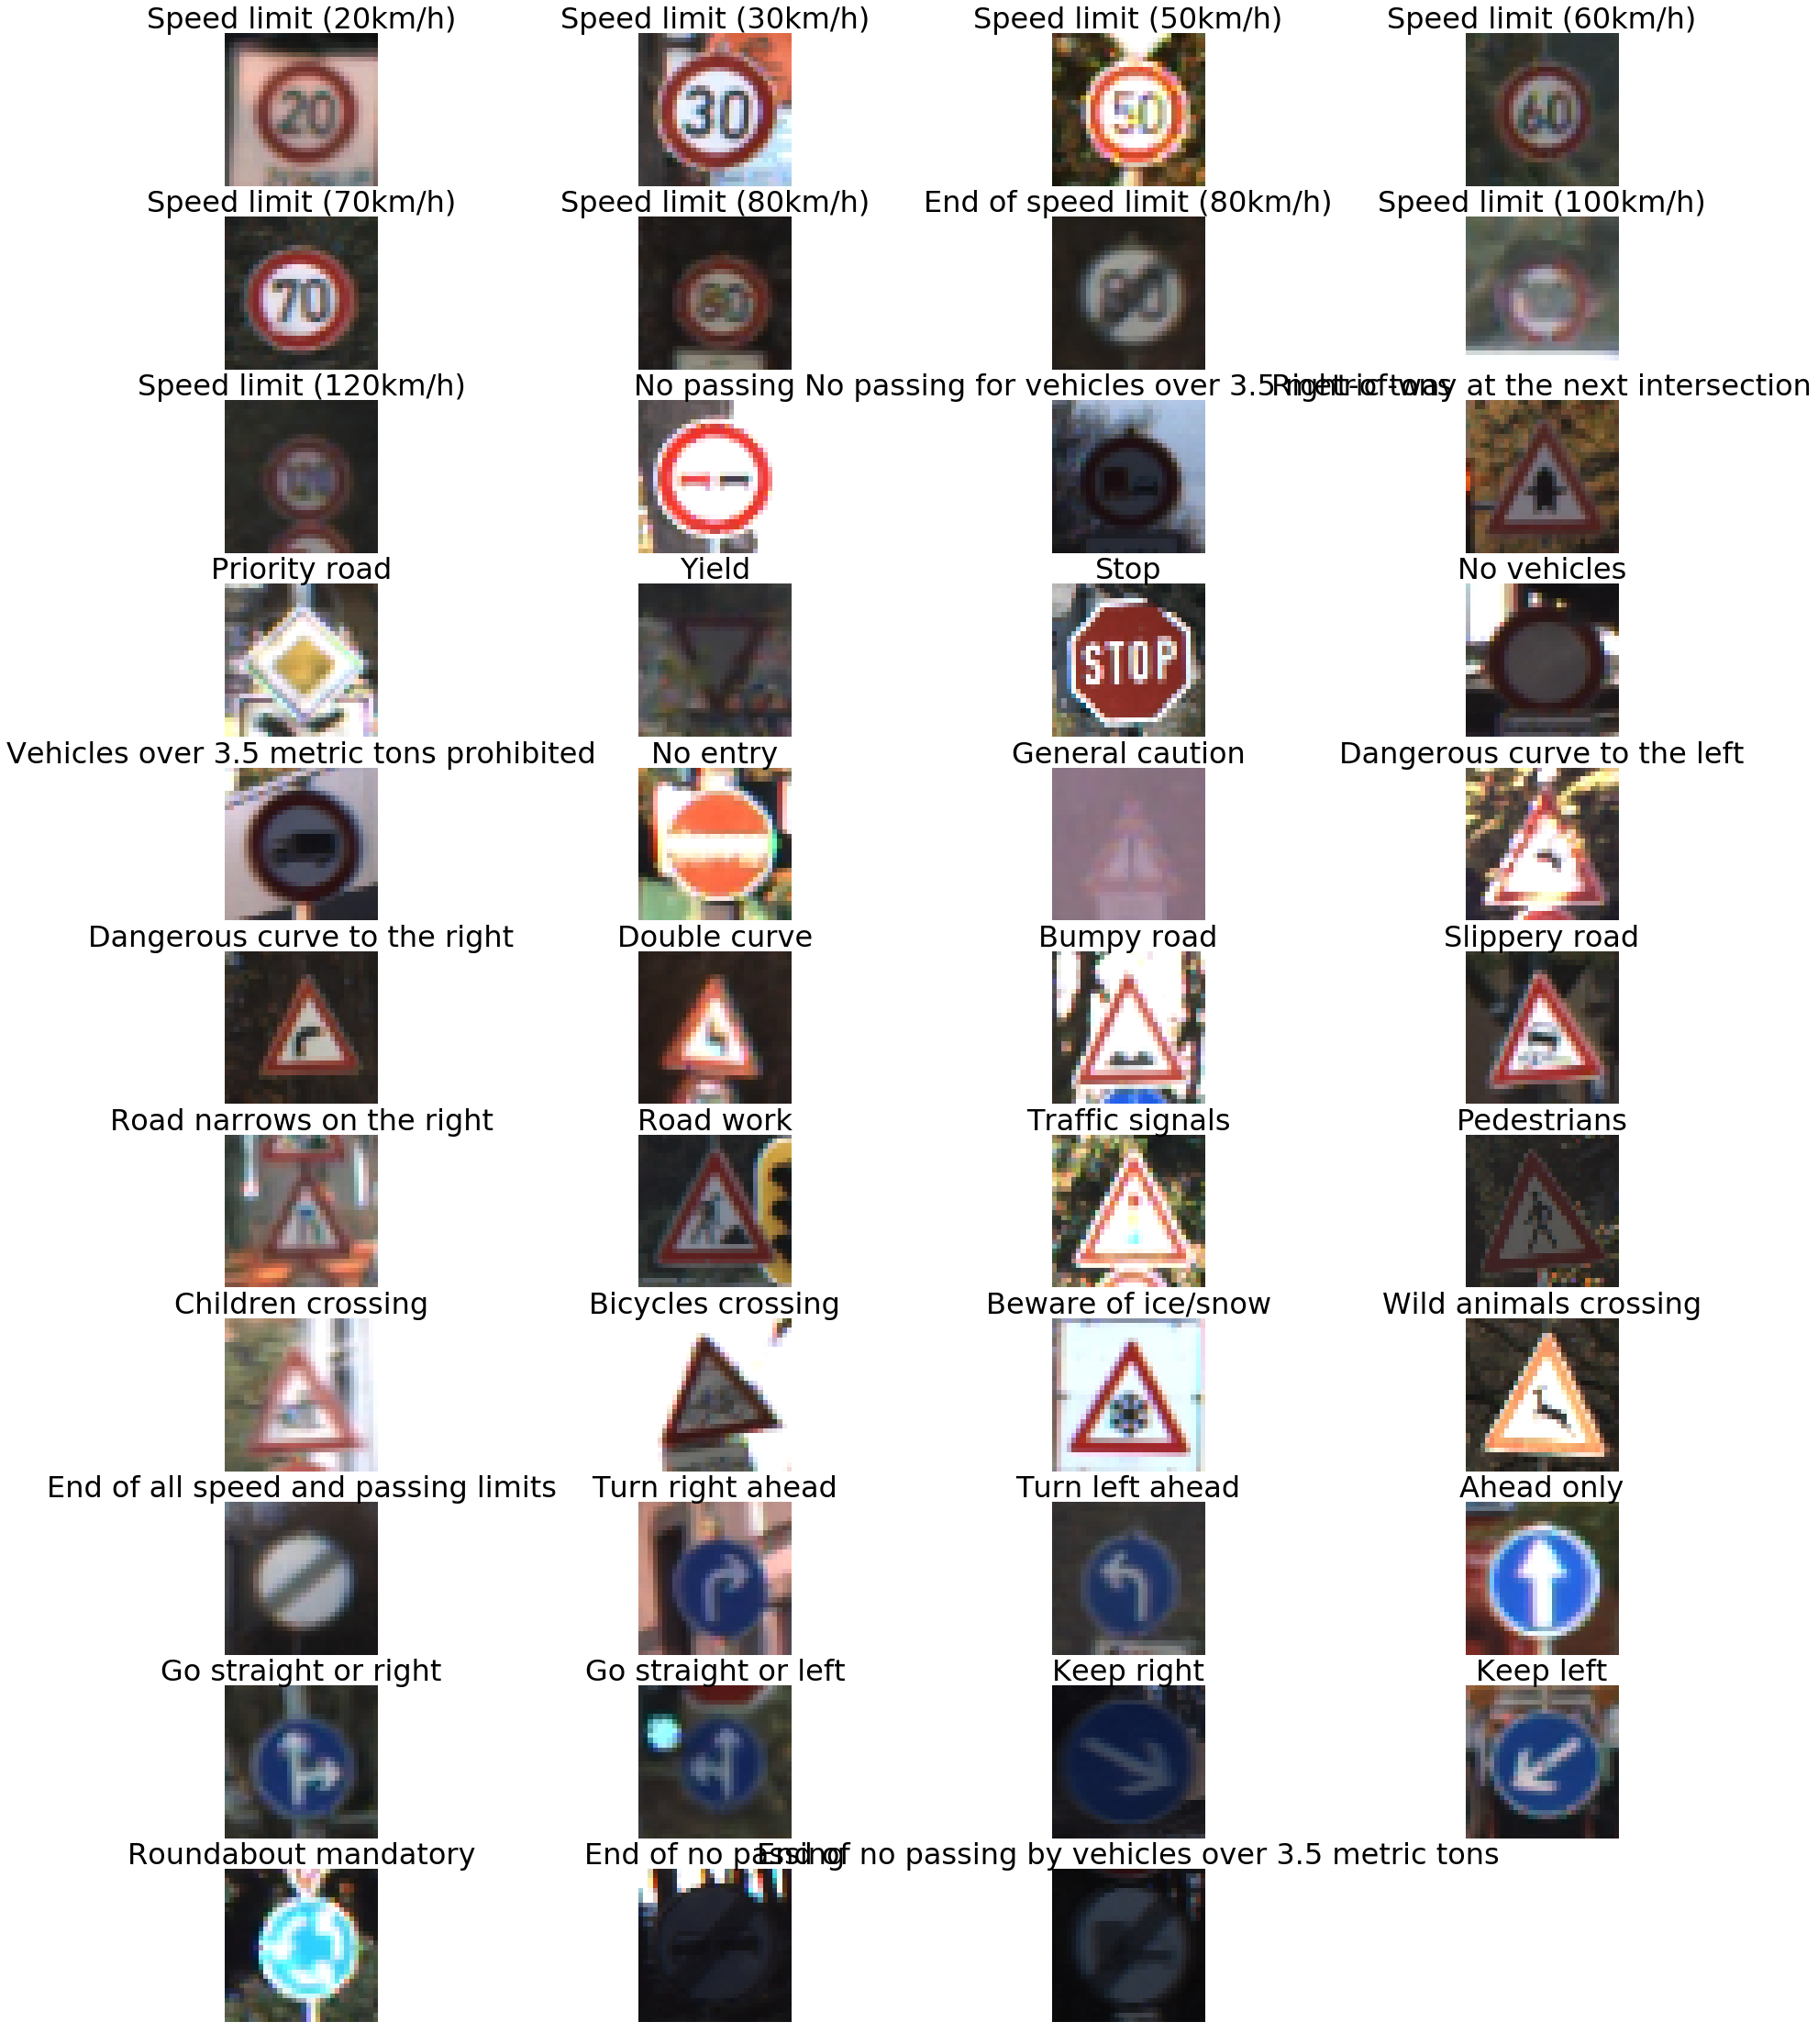

In [10]:
data_exp.show_images_each_class()

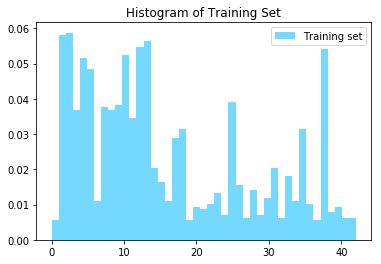

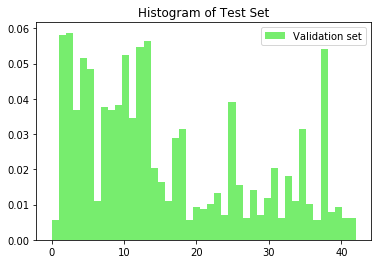

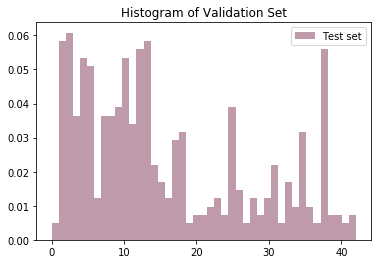

In [11]:
data_exp.draw_histogram()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [12]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
db.shuffle_training_data()
# db.normalize(db.X_train)
# db.normalize(db.X_test)
# db.normalize(db.X_validation)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [13]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [14]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten


class LeNet:
    def __init__(self, db, epochs=10, batch_size=128, mu=0, sigma=0.1, rate = 0.001):
        self.db = db
        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size
        self.mu = mu
        self.sigma = sigma
        self.rate = rate
        self.x = tf.placeholder(tf.float32, (None, 32, 32, 3))
        self.y = tf.placeholder(tf.int32, (None))
        self.keep_prob = tf.placeholder(tf.float32)
        self.one_hot_y = tf.one_hot(self.y, 43)
#         print ()
#         print ('LeNet Parameters')
#         print ('----------------')
#         print ('--EPOCHS', self.EPOCHS,
#                '--BATCH_SIZE', self.BATCH_SIZE,
#                '--mu', self.mu,
#                '--sigma', self.sigma,
#                '--rate', self.rate)

    

        
    def define_conv_network(self):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
        # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x12.
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 12), mean = self.mu, stddev = self.sigma))
        conv1_b = tf.Variable(tf.zeros(12))
        conv1   = tf.nn.conv2d(self.x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)
        # Pooling. Input = 28x28x12. Output = 26x26x12.
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='VALID')

        # Layer 2: Convolutional. Input = 26x26x12   Output = 24x24x24.
        conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 12, 24), mean = self.mu, stddev = self.sigma))
        conv2_b = tf.Variable(tf.zeros(24))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)
        # Pooling. Input = 24x24x24. Output = 12x12x24.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # Layer 3: Convolutional. Input = 12x12x24   Output = 10x10x32.
        conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 24, 32), mean = self.mu, stddev = self.sigma))
        conv3_b = tf.Variable(tf.zeros(32))
        conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
        conv3 = tf.nn.relu(conv3)
        # Pooling. Input = 10x10x32. Output = 5x5x32.
        conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # Layer 4: Convolutional. Input = 5x5x32   Output = 3x3x64
        conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        conv4_b = tf.Variable(tf.zeros(64))
        conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
        conv4 = tf.nn.relu(conv4)
        # Pooling. Input = 10x10x32. Output = 5x5x32.
#         conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        conv4 = tf.nn.dropout(conv4, self.keep_prob)

        # Flatten. Input = 5x5x16. Output = 400.
        fc0   = flatten(conv4)

        # FC Layer 1: Fully Connected. Input = 400. Output = 120.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(576, 480), mean = self.mu, stddev = self.sigma))
        fc1_b = tf.Variable(tf.zeros(480))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
        fc1    = tf.nn.relu(fc1)

        # Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(480, 384), mean = self.mu, stddev = self.sigma))
        fc2_b  = tf.Variable(tf.zeros(384))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
        fc2    = tf.nn.relu(fc2)

        # Layer 4: Fully Connected. Input = 120. Output = 84.
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(384, 288), mean = self.mu, stddev = self.sigma))
        fc3_b  = tf.Variable(tf.zeros(288))
        fc3    = tf.matmul(fc2, fc3_W) + fc3_b
        fc3    = tf.nn.relu(fc3)

        # Layer 4: Fully Connected. Input = 120. Output = 84.
        fc4_W  = tf.Variable(tf.truncated_normal(shape=(288, 192), mean = self.mu, stddev = self.sigma))
        fc4_b  = tf.Variable(tf.zeros(192))
        fc4    = tf.matmul(fc3, fc4_W) + fc4_b
        fc4    = tf.nn.relu(fc4)

        # Layer 4: Fully Connected. Input = 120. Output = 84.
        fc5_W  = tf.Variable(tf.truncated_normal(shape=(192, 96), mean = self.mu, stddev = self.sigma))
        fc5_b  = tf.Variable(tf.zeros(96))
        fc5    = tf.matmul(fc4, fc5_W) + fc5_b
        fc5    = tf.nn.relu(fc5)


        # Layer 5: Fully Connected. Input = 84. Output = 10.
        fc6_W  = tf.Variable(tf.truncated_normal(shape=(96, 43), mean = self.mu, stddev = self.sigma))
        fc6_b  = tf.Variable(tf.zeros(43))
        
        self.logits = tf.matmul(fc5, fc6_W) + fc6_b
        

#     def prepare_to_train(self):
#         self.define_conv_network() # LeNet
#         self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, self.one_hot_y)
#         self.loss = tf.reduce_mean(self.cross_entropy)
#         self.optimizer = tf.train.AdamOptimizer(learning_rate = self.rate)
#         self.training_operation = self.optimizer.minimize(self.loss)
#         correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
#         self.accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#         self.saver = tf.train.Saver()
#         self.merged_summaries = tf.summary.merge_all()
#         self.merged_summaries = tf.merge_summary([w1_hist, b1_hist, w2_hist, b2_hist, y_hist, cost_summ])

    def evaluate(self, X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, self.BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+self.BATCH_SIZE], y_data[offset:offset+self.BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, feed_dict={self.x: batch_x, self.y: batch_y, self.keep_prob:1.0})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

    
    # New Evaluate function as we don't want Batch Size here
    def evaluate_new_images(self,X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        accuracy = sess.run(self.accuracy_operation, feed_dict={self.x: X_data, self.y: y_data, self.keep_prob:1.0})
        total_accuracy += (accuracy * len(X_data))
        return total_accuracy / num_examples    

    def predict(self, test_images, test_labels):
        with tf.Session() as sess:
#             sess.run(tf.global_variables_initializer())
#             loader = tf.train.import_meta_graph('lenet.meta')
            self.saver.restore(sess, tf.train.latest_checkpoint('./'))
            test_accuracy = self.evaluate(test_images, test_labels)
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            sess.close()  
            return test_accuracy
            
    
    def predict2(self, test_images, test_labels):
#         x = tf.placeholder(tf.float32, (None, 32, 32, 3))
        #keep_prob = tf.placeholder(tf.float32)
        predictSoftmax = tf.nn.softmax(self.logits)

        with tf.Session() as sess:
#             loader = tf.train.import_meta_graph('lenet.meta')
#             loader.restore(sess, tf.train.latest_checkpoint('.'))
            #saver.restore(sess, 'folder name/')
            self.saver.restore(sess, tf.train.latest_checkpoint('./'))
            print("Model restored")
            # for images from internet
            softmaxProb = sess.run(
                predictSoftmax, 
#                 self.logits,
                feed_dict={self.x: test_images, self.keep_prob:1.0})
            test_accuracy = self.evaluate_new_images(test_images, test_labels)
            top_k = sess.run(tf.nn.top_k(tf.constant(softmaxProb), k=43))
            print("Test Accuracy = {:.3f}".format(test_accuracy))
        return {'softmaxProb':softmaxProb, 'top_k':top_k}

    
    def train(self):
        import datetime

        self.define_conv_network() # LeNet
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, self.one_hot_y)
        self.loss = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.rate)
        self.training_operation = self.optimizer.minimize(self.loss)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.saver = tf.train.Saver()
        self.merged_summaries = tf.summary.merge_all()
        tf.summary.scalar('loss', self.loss)
        tf.summary.scalar('accuracy', self.accuracy_operation)
        

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            self.summary_writer = tf.summary.FileWriter("./logs/" + "train_" +
                                                            datetime.datetime.now().strftime("%Y-%m-%d--%H:%M:%S"),
                                                            sess.graph)
#             self.summary_writer = tf.train.SummaryWriter("./logs/" +
#                                                   '/train' + 
#                                                   datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
#                                                   sess.graph)    

            num_examples = len(self.db.X_train)

#             print("Training...")
#             print()
            for i in range(self.EPOCHS):
                self.db.X_train, self.db.y_train = shuffle(self.db.X_train, self.db.y_train)
                for offset in range(0, num_examples, self.BATCH_SIZE):
                    end = offset + self.BATCH_SIZE
                    batch_x, batch_y = self.db.X_train[offset:end], self.db.y_train[offset:end]

#                     tf_merged_summaries, 
                    _, tf_loss, tf_accuracy = sess.run(
                        [
#                             self.merged_summaries, 
                            self.training_operation,
                            self.loss, 
                            self.accuracy_operation
                        ],
                        feed_dict={self.x: batch_x, self.y: batch_y, self.keep_prob:0.5})
#                     ,  tf_cross_entropy, tf_loss, tf_optimizer, tf_training_operation
                   
#                                 ,
#                                              self.cross_entropy,
#                                              self.loss,
#                                              self.training_operation
                                                                                                                   
#                     sess.run([self.training_operation], feed_dict={self.x: batch_x, self.y: batch_y})

#                     self.summary_writer.add_summary(tf_merged_summaries, i)
#                  if i == (self.EPOCHS-1):
#                     self.summary_writer.flush()

                self.validation_accuracy = self.evaluate(self.db.X_validation, self.db.y_validation)
        #         validation_summary = tf.summary.scalar("validation_accuracy", validation_accuracy)
        #         self.summary_writer.add_summary(summary, i)
        #         self.summary_writer.flush()

#                 if i == (self.EPOCHS-1):
#                     print('Accuracy {0:8.2f}%, loss {1:8.2f}'.format(tf_accuracy*100, tf_loss))
                print("EPOCH {} ...".format(i+1),"Validation Accuracy = {:.3f}".format(
                    self.validation_accuracy))

            self.saver.save(sess, 'lenet')
            print("Model saved")
            sess.close()

    def find_test_accuracy(self):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            loader = tf.train.import_meta_graph('lenet.meta')
            loader.restore(sess, tf.train.latest_checkpoint('./'))
            test_accuracy = self.evaluate(self.db.X_test, self.db.y_test)
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            sess.close()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [15]:
### Train your model here.
### Feel free to use as many code cells as needed.
# le_net = LeNet(db)
# # le_net.prepare_to_train()
# le_net.train()
tf.reset_default_graph()


In [16]:
import time


In [17]:
le_net = None

for i in range(1):

    rate = 0.0005 + (i*0.0001)
    
    for j in range(8,9):
        batch_size = 2**j
        for k in range(1,2):
            print ()
            print ('rate', rate, 'batch_size', 2**j, 'normalize_method', k)    
            db = Database(training_file, testing_file)
            db.load()
#             db.augment_training_data()
            db.split_to_validation(0.2, 0)
            db.check_assertions()
            db.shuffle_training_data()

            if (k == 0):
                db.X_train = db.normalize_color(db.X_train)
                db.X_test = db.normalize_color(db.X_test)
            elif(k == 1):
                db.augment_training_data()
                db.X_train = db.normalize_color(db.X_train)
                db.X_test = db.normalize_color(db.X_test)


            start = time.clock()
            le_net = LeNet(db=db, rate=rate, epochs=50)
            le_net.train()
            le_net.find_test_accuracy()
#             tf.reset_default_graph()
            print (time.clock() - start)




rate 0.0003 batch_size 256 normalize_method 1
Loading Databse
Splitting 20.0% training set for validation
Data is valid
EPOCH 1 ... Validation Accuracy = 0.645
EPOCH 2 ... Validation Accuracy = 0.862
EPOCH 3 ... Validation Accuracy = 0.884
EPOCH 4 ... Validation Accuracy = 0.934
EPOCH 5 ... Validation Accuracy = 0.949
EPOCH 6 ... Validation Accuracy = 0.957
EPOCH 7 ... Validation Accuracy = 0.967
EPOCH 8 ... Validation Accuracy = 0.969
EPOCH 9 ... Validation Accuracy = 0.969
EPOCH 10 ... Validation Accuracy = 0.958
Model saved
Test Accuracy = 0.925
31.515815999999997


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

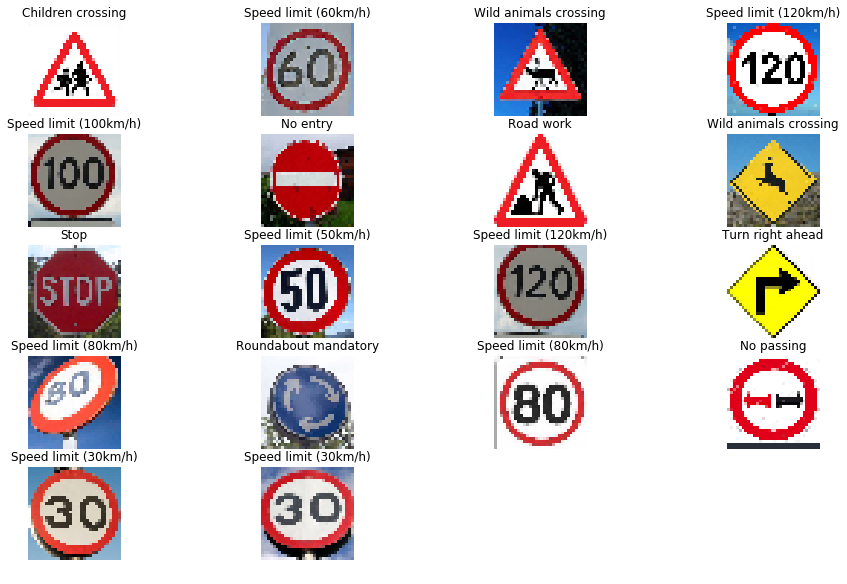

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# Let's read the 6 candidate images
import cv2
import os 


# temp = os.listdir("traffic_sign_images")
temp = os.listdir("img_bak")
imagesTogether = []	

for i in range(len(temp)):
#     image = cv2.resize(cv2.imread("traffic_sign_images/"+temp[i]),(32,32))
    image = cv2.resize(cv2.imread("img_bak/"+temp[i]),(32,32))
    b, g, r = cv2.split(image)
    image = cv2.merge((r, g, b))
    imagesTogether.append(image)
    
imagesTogether = np.asarray(imagesTogether)

    
    
# ClassId	SignName
# 0	Speed limit (20km/h)
# 1	Speed limit (30km/h)
# 2	Speed limit (50km/h)
# 3	Speed limit (60km/h)
# 4	Speed limit (70km/h)
# 5	Speed limit (80km/h)
# 6	End of speed limit (80km/h)
# 7	Speed limit (100km/h)
# 8	Speed limit (120km/h)
# 9	No passing
# 10	No passing for vehicles over 3.5 metric tons
# 11	Right-of-way at the next intersection
# 12	Priority road
# 13	Yield
# 14	Stop
# 15	No vehicles
# 16	Vehicles over 3.5 metric tons prohibited
# 17	No entry
# 18	General caution
# 19	Dangerous curve to the left
# 20	Dangerous curve to the right
# 21	Double curve
# 22	Bumpy road
# 23	Slippery road
# 24	Road narrows on the right
# 25	Road work
# 26	Traffic signals
# 27	Pedestrians
# 28	Children crossing
# 29	Bicycles crossing
# 30	Beware of ice/snow
# 31	Wild animals crossing
# 32	End of all speed and passing limits
# 33	Turn right ahead
# 34	Turn left ahead
# 35	Ahead only
# 36	Go straight or right
# 37	Go straight or left
# 38	Keep right
# 39	Keep left
# 40	Roundabout mandatory
# 41	End of no passing
# 42	End of no passing by vehicles over 3.5 metric tons    
    
test_labels = [28, 3, 31, 8, 7, 17, 25, 31, 14, 2, 8, 33, 5, 40, 5, 9, 1, 1]
# test_labels =  [1,0,3,5,3,28]

index = 0


fig = plt.figure(figsize=(16, 16))
for image in imagesTogether:
#     print (image)

    index += 1
    plt.subplot(8, 4, index)
#             plt.subplots_adjust(hspace=0.7)
    plt.axis('off')
#     fig.subplots_adjust(left=0.15, top=0.15)

    sign_name = le_net.db.signs.SignName[test_labels[index-1]]
#     plt.title(self.db.signs.SignName[c], fontsize=32)
    plt.title(sign_name)
    plt.imshow(image)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [19]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
# tf.reset_default_graph()
print (test_labels)
imagesTogether_train = le_net.db.normalize_color(imagesTogether)

tf_logits = le_net.predict2(imagesTogether_train, test_labels)

# print (tf_logits)


[28, 3, 31, 8, 7, 17, 25, 31, 14, 2, 8, 33, 5, 40, 5, 9, 1, 1]
Model restored
Test Accuracy = 0.333


In [20]:
# print (imagesTogether_train)

In [25]:
ee = tf_logits['softmaxProb']

# for i in ee:
# #     tmp = 100*(ee[i][0])/sum(ee[i])
#     plt.bar(top_indice[i], top_pred[i])
#     plt.show()
#     print tmp
print (ee[0])


[  1.31803972e-07   1.33402411e-09   1.06874537e-10   1.95292768e-10
   2.84291823e-18   2.99709720e-13   1.63053564e-16   2.02300871e-12
   1.46000006e-13   2.47234741e-13   1.80301846e-12   8.48263824e-08
   6.60934415e-13   4.68403820e-16   4.68044392e-18   1.93978287e-17
   1.56447511e-11   1.78921859e-13   2.94947705e-10   2.61277523e-12
   2.42335396e-03   2.72363105e-13   4.38932744e-11   3.17042577e-06
   1.40062690e-08   2.60783395e-10   1.32886563e-10   1.85904847e-10
   9.97563839e-01   9.45999091e-06   1.72423287e-09   2.66787985e-14
   6.07612922e-18   2.18349051e-14   1.92652291e-14   9.69230918e-10
   2.63190164e-12   2.53831824e-15   5.51544180e-16   1.02092929e-13
   1.93537504e-12   9.27030233e-16   5.71295586e-20]


Certainty percentage: 99.76%


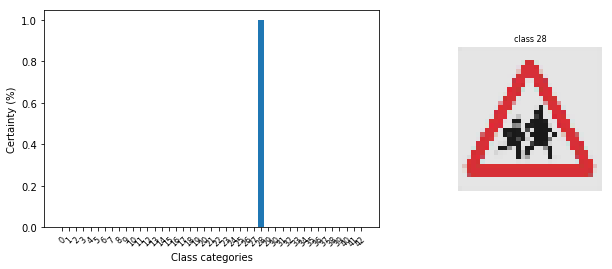

Certainty percentage: 80.85%


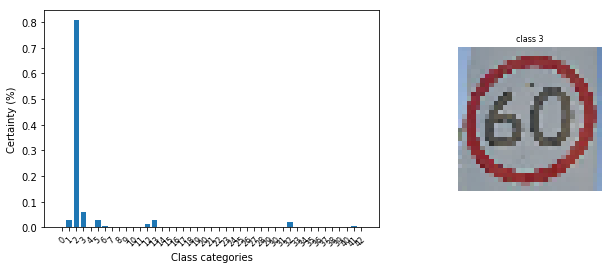

Certainty percentage: 98.60%


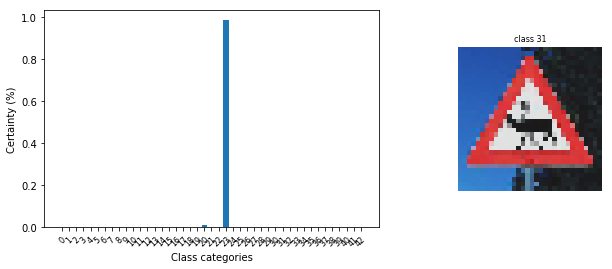

Certainty percentage: 89.17%


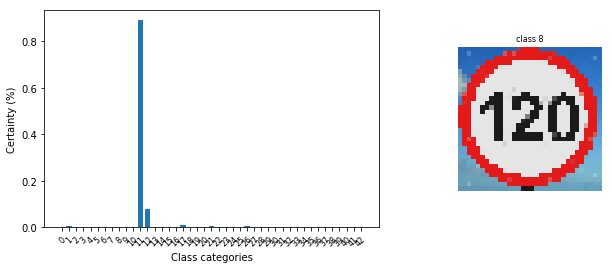

Certainty percentage: 45.36%


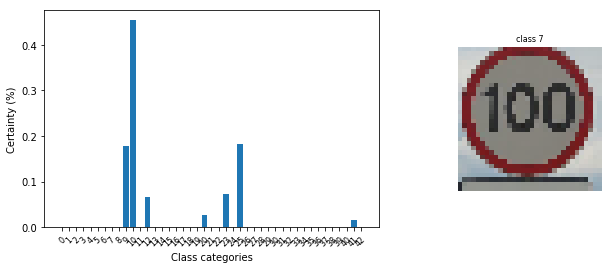

Certainty percentage: 99.17%


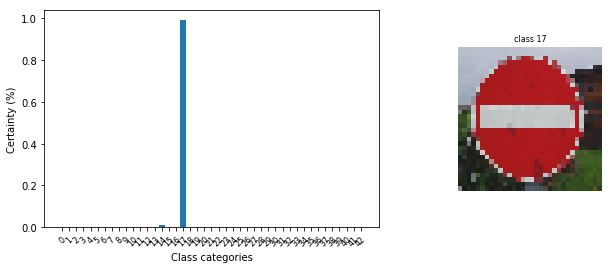

Certainty percentage: 99.94%


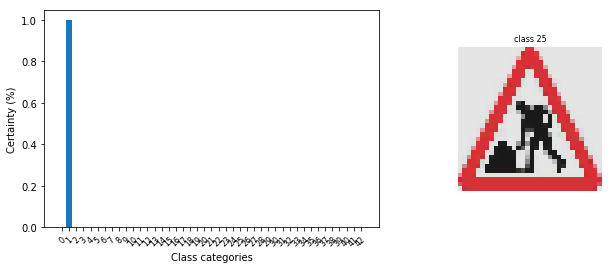

Certainty percentage: 69.43%


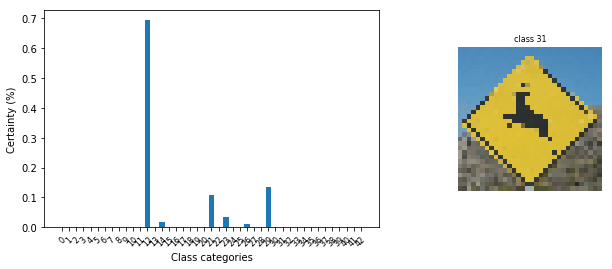

Certainty percentage: 71.90%


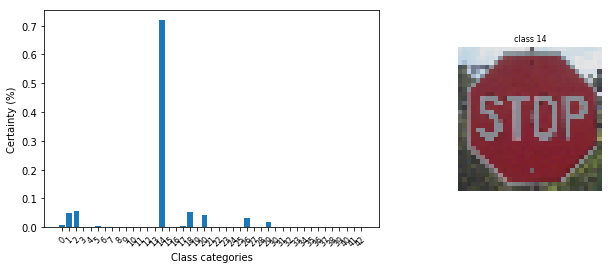

Certainty percentage: 97.74%


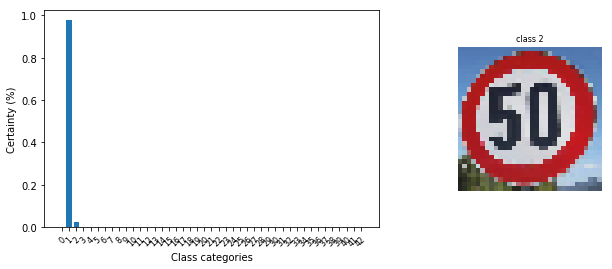

Certainty percentage: 64.91%


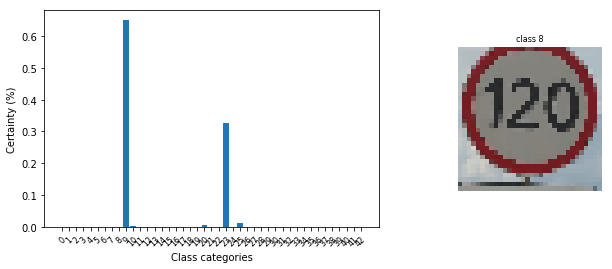

Certainty percentage: 99.76%


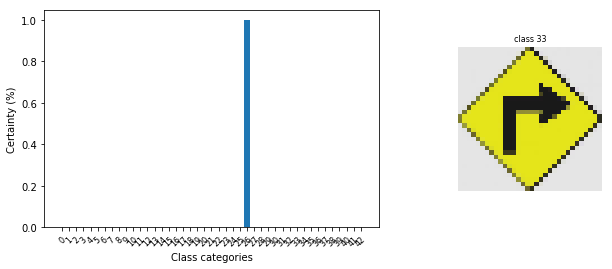

Certainty percentage: 35.75%


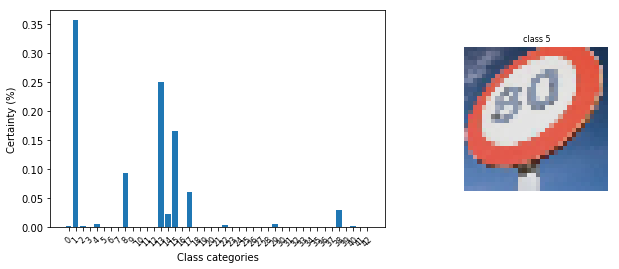

Certainty percentage: 59.20%


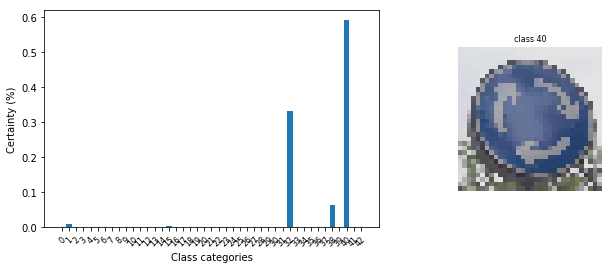

Certainty percentage: 98.81%


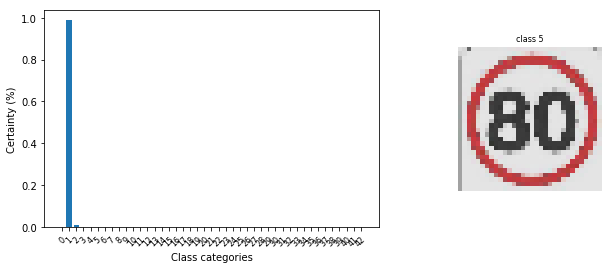

Certainty percentage: 99.60%


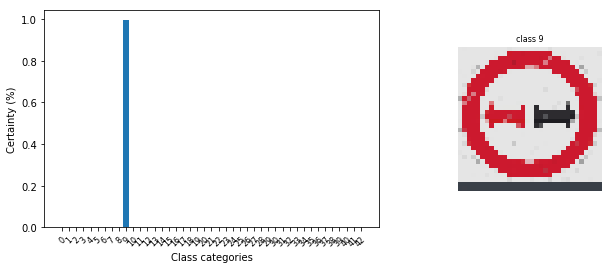

Certainty percentage: 95.76%


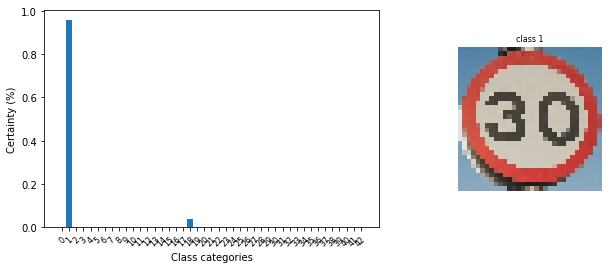

Certainty percentage: 30.14%


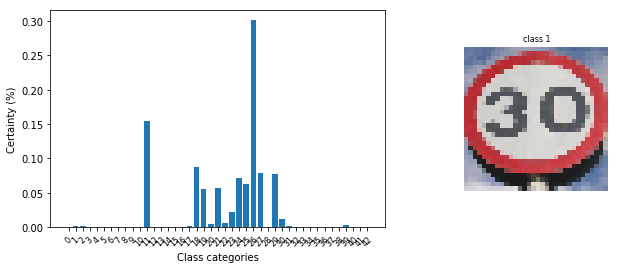

[  9.97563839e-01   2.42335396e-03   9.45999091e-06   3.17042577e-06
   1.31803972e-07   8.48263824e-08   1.40062690e-08   1.72423287e-09
   1.33402411e-09   9.69230918e-10   2.94947705e-10   2.60783395e-10
   1.95292768e-10   1.85904847e-10   1.32886563e-10   1.06874537e-10
   4.38932744e-11   1.56447511e-11   2.63190164e-12   2.61277523e-12
   2.02300871e-12   1.93537504e-12   1.80301846e-12   6.60934415e-13
   2.99709720e-13   2.72363105e-13   2.47234741e-13   1.78921859e-13
   1.46000006e-13   1.02092929e-13   2.66787985e-14   2.18349051e-14
   1.92652291e-14   2.53831824e-15   9.27030233e-16   5.51544180e-16
   4.68403820e-16   1.63053564e-16   1.93978287e-17   6.07612922e-18
   4.68044392e-18   2.84291823e-18   5.71295586e-20]
[28 20 29 23  0 11 24 30  1 35 18 25  3 27 26  2 22 16 36 19  7 40 10 12  5
 21  9 17  8 39 31 33 34 37 41 38 13  6 15 32 14  4 42]


In [31]:
top_pred, top_indice = tf_logits['top_k']


# class_list = [1,13,40,3,33,24]

#print(top_pred, top_indice)
for i in range(len(test_labels)):
    plt.bar(top_indice[i], top_pred[i])
    tmp = 100*(top_pred[i][0])/sum(top_pred[i])
    plt.xticks(np.arange(0,43,1.0),rotation=45, fontsize=8)
    plt.ylabel('Certainty (%)')
    plt.xlabel('Class categories')

    ax = plt.axes([1.0,.25,.5,.5], frameon=True)
    ax.imshow(imagesTogether_train[i])
    index += 1
    ax.set_title('class '+str(test_labels[i]), fontsize=8)
    ax.axis('off')
    print('Certainty percentage: {0:4.2f}%'.format(tmp))
    plt.show()

print (top_pred[0])
print (top_indice[0])


In [ ]:

index = 0
fig = plt.figure(figsize=(16, 16))
for image in imagesTogether:
#     print (image)

    index += 1
    plt.subplot(8, 4, index)
#             plt.subplots_adjust(hspace=0.7)
    plt.axis('off')
#     fig.subplots_adjust(left=0.15, top=0.15)

    sign_name = le_net.db.signs.SignName[ee.indices[index-1][0]]
#     plt.title(self.db.signs.SignName[c], fontsize=32)
    plt.title(sign_name)
    plt.imshow(image)


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.